### Cleaned vs Dirty V2
##### Classify if a plate is cleaned or dirty?
тип задачи - классификация \
метрика качества - accuracy(доля правильных ответов) \
transfer learning - дообучение готовой архитектуры 

Основная идея решения - дообучить ResNet 

In [41]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import copy

In [42]:
import os
import zipfile

with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
    zip_obj.extractall('/kaggle/working/')
data_root = '/kaggle/working/plates/'

In [43]:
#data_root = 'plates/'

Для создания train и validation выборок, создадим и заполним 2 папки:

In [44]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']
#все картинки разбиваются на классы
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
#каждая 6 картинка помещается в папку validation
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 391.50it/s]


In [45]:
!ls train

cleaned  dirty


### Предобработка
<b>torchvision.datasets.ImageFolder</b>
 - предоставляет возможность итерирования по изображениям, запомнит в какой папке-классе оно находилось
 - помогает получать изображения в виде тензоров
 
<b>transforms.Compose</b>
 - сжатие картинки до определенного размера
 - превращение ее в тензор
 - от каждого цвета отнимаются константы, т.к. на таких примерах обучался ResNet

In [46]:
import torch
import torchvision

from torchvision import transforms, models

#Аугментации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), #вырезается прямоугольная часть и увеличивается до 224
    transforms.RandomHorizontalFlip(), #отзеркаливание
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

In [47]:
#num_workers - количество потоков выполняющих трансформации
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

permute - меняет местами размерности тензора Х
 - до .toTenzor: высота, ширина, каналы
 - после: каналы, высота, ширина  
 
permute+обратная нормировка = исходное изображение

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


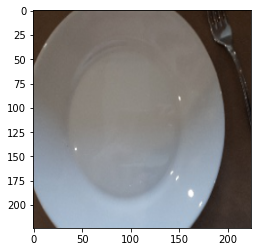

In [48]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

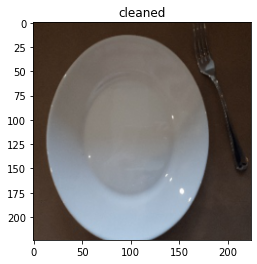

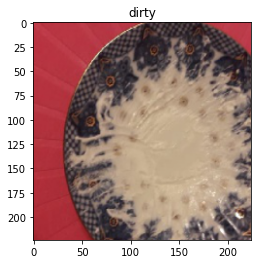

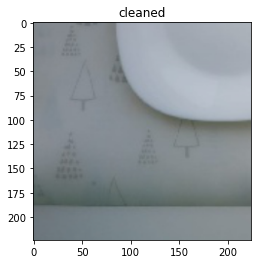

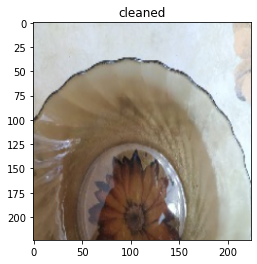

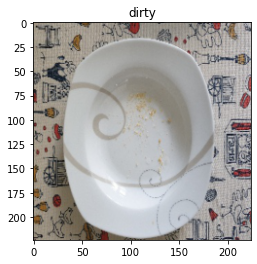

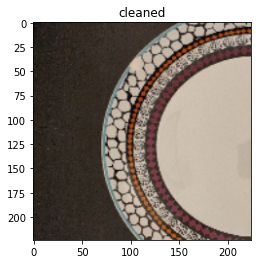

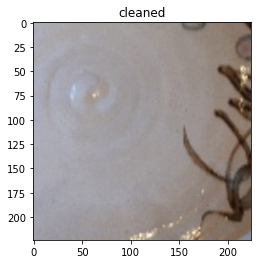

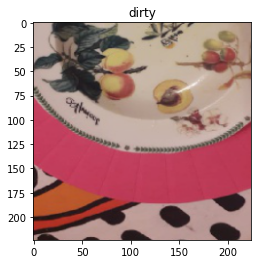

In [49]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

### Создание модели

In [50]:
model = models.resnet18(pretrained=True)

# для всех слоев отменяем вычисление градиентного спуска 
#т.к. параметры нас устраивают, модель уже обучена, осталось обучить последний слой - классификатор
for param in model.parameters():
    param.requires_grad = False


model.fc = torch.nn.Linear(model.fc.in_features, 2)


#перекладывание модели на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Бинарная кросс-энтропия получает активации нейронов
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) #градиентный спуск lr - learning rate

# уменьшение lr с течением времени
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [51]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    #итератор по эпохам
    for epoch in range(num_epochs): 
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1) #чтобы узнать предсказанный класс

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [52]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.7606 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

val Loss: 0.9259 Acc: 0.5000
Epoch 1/9:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.7057 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 0.9256 Acc: 0.2500
Epoch 2/9:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.7663 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 1.0124 Acc: 0.3750
Epoch 3/9:



100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

train Loss: 0.7062 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

val Loss: 0.9160 Acc: 0.2500
Epoch 4/9:



100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

train Loss: 0.5745 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

val Loss: 0.9258 Acc: 0.3750
Epoch 5/9:



100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

train Loss: 0.5987 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

val Loss: 0.9148 Acc: 0.3750
Epoch 6/9:



100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

train Loss: 0.6442 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

val Loss: 0.9203 Acc: 0.3750
Epoch 7/9:



100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

train Loss: 0.5505 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

val Loss: 0.9074 Acc: 0.3750
Epoch 8/9:



100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

train Loss: 0.5184 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

val Loss: 0.8931 Acc: 0.2500
Epoch 9/9:



100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

train Loss: 0.5759 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

val Loss: 0.8904 Acc: 0.2500


In [65]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [66]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [67]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [68]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


In [69]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [70]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
test/unknown/0000,dirty
test/unknown/0001,cleaned
test/unknown/0002,cleaned
test/unknown/0003,dirty
test/unknown/0004,cleaned
test/unknown/0005,dirty


In [71]:
submission_df.to_csv('submission.csv')

In [72]:
!rm -rf train val test